In [9]:
import fastf1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fastf1.set_log_level('WARNING')

In [2]:
df = pd.read_pickle("race_data_2018_to_2023.pkl")
df.info()

<class 'fastf1.core.Laps'>
RangeIndex: 136877 entries, 0 to 136876
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   Year                136877 non-null  int64          
 1   RaceName            136877 non-null  object         
 2   Driver              136877 non-null  object         
 3   DriverNumber        136877 non-null  object         
 4   LapTime             133640 non-null  timedelta64[ns]
 5   LapNumber           136877 non-null  float64        
 6   Stint               136534 non-null  float64        
 7   PitOutTime          4414 non-null    timedelta64[ns]
 8   PitInTime           4562 non-null    timedelta64[ns]
 9   Sector1Time         135669 non-null  timedelta64[ns]
 10  Sector2Time         136561 non-null  timedelta64[ns]
 11  Sector3Time         136430 non-null  timedelta64[ns]
 12  Position            136699 non-null  float64        
 13  CumulativeTimeAtS1  13566

In [11]:
bpdf = pd.read_csv("AWS_battle_predictions_2023.csv")
bpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    19 non-null     int64  
 1   RaceName                19 non-null     object 
 2   ChasingBehind           19 non-null     object 
 3   ChasingFront            19 non-null     object 
 4   LeadLapofthePrediction  19 non-null     int64  
 5   PredictedLaps           19 non-null     int64  
 6   GapatPrediction         19 non-null     float64
 7   Difficulty              0 non-null      float64
dtypes: float64(2), int64(3), object(3)
memory usage: 1.3+ KB


In [12]:
def evaluate_prediction_api(year, racename, driver_behind, driver_front, lap_of_prediction, predicted_laps, gap_at_prediction):
    # Load session data
    session = fastf1.get_session(year, racename, 'R')
    session.load()

    # Get driver data
    driver_behind_data = session.laps.pick_driver(driver_behind)
    driver_front_data = session.laps.pick_driver(driver_front)

    # Add CumulativeTime columns
    driver_behind_data['CumulativeTime'] = driver_behind_data['LapTime'].cumsum()
    driver_front_data['CumulativeTime'] = driver_front_data['LapTime'].cumsum()

    # Calculate CumulativeTimeAtS1 and CumulativeTimeAtS2
    driver_behind_data['CumulativeTimeAtS1'] = driver_behind_data['CumulativeTime'].shift(1) + driver_behind_data['Sector1Time']
    driver_behind_data['CumulativeTimeAtS2'] = driver_behind_data['CumulativeTimeAtS1'] + driver_behind_data['Sector2Time']

    driver_front_data['CumulativeTimeAtS1'] = driver_front_data['CumulativeTime'].shift(1) + driver_front_data['Sector1Time']
    driver_front_data['CumulativeTimeAtS2'] = driver_front_data['CumulativeTimeAtS1'] + driver_front_data['Sector2Time']
        
    # Filter data for the relevant laps
    driver_behind_data = driver_behind_data[(driver_behind_data['LapNumber'] >= lap_of_prediction - 1) & (driver_behind_data['LapNumber'] <= lap_of_prediction + predicted_laps)]
    driver_front_data = driver_front_data[(driver_front_data['LapNumber'] >= lap_of_prediction - 1) & (driver_front_data['LapNumber'] <= lap_of_prediction + predicted_laps)]

    # Initialize result dictionary
    result = {'prediction': False, 'voided': False, 'void_due_data': False, 'error': None, 'gap_diff': None}

    # Get data for the lap of prediction
    prediction_lap_data_behind = driver_behind_data[driver_behind_data['LapNumber'] == lap_of_prediction - 1]
    prediction_lap_data_front = driver_front_data[driver_front_data['LapNumber'] == lap_of_prediction - 1]

    # If prediction_lap_data is not empty, check the gap
    if not prediction_lap_data_behind.empty and not prediction_lap_data_front.empty:
        # Calculate gap at end of lap
        gap = (prediction_lap_data_behind['CumulativeTime'].values[0] - prediction_lap_data_front['CumulativeTime'].values[0]).astype(float) / 1e9


        # Check if gap is within 25% margin of error
        result['gap_diff'] = abs(gap - gap_at_prediction)
        if result['gap_diff'] > 0.25 * gap_at_prediction:
            result['voided'] = True
            result['void_due_data'] = True
    else:
        result['voided'] = True
        result['void_due_data'] = True
        return result  
    
    # Loop through filtered data
    for i in range(lap_of_prediction, lap_of_prediction + predicted_laps):
        # Get data for current lap
        current_lap_data_behind = driver_behind_data[driver_behind_data['LapNumber'] == i]
        current_lap_data_front = driver_front_data[driver_front_data['LapNumber'] == i]

        # If current_lap_data is empty, continue to the next iteration
        if current_lap_data_behind.empty or current_lap_data_front.empty:
            continue

        # Calculate gaps at each sector
        for sector in ['CumulativeTimeAtS1', 'CumulativeTimeAtS2', 'CumulativeTime']:
            gap = (current_lap_data_behind[sector].values[0] - current_lap_data_front[sector].values[0]).astype(float) / 1e9
            
            # Check if prediction is correct
            if gap < 1:
                result['prediction'] = True
                return result

        # Check if prediction is void due to pit stop or track status
        if pd.notnull(current_lap_data_behind['PitInTime'].values[0]) or pd.notnull(current_lap_data_front['PitInTime'].values[0]) or current_lap_data_behind['TrackStatus'].values[0] not in ['1', '2'] or current_lap_data_front['TrackStatus'].values[0] not in ['1', '2']:
            result['voided'] = True
            return result

    # If loop completes without returning, prediction was incorrect

    result['error'] = gap - 1

    return result

In [13]:
def evaluate_predictions(prediction_data):
    for index, row in prediction_data.iterrows():
        result = evaluate_prediction_api(row['Year'], row['RaceName'], row['ChasingBehind'], row['ChasingFront'], 
                                     row['LeadLapofthePrediction'], row['PredictedLaps'], row['GapatPrediction'])
        
        # Write results in columns 8-11
        prediction_data.at[index, 'isAccurate'] = result['prediction']
        prediction_data.at[index, 'isVoided'] = result['voided']
        prediction_data.at[index, 'Error'] = round(result['error'], 3) if result['error'] is not None else None
        prediction_data.at[index, 'gap_diff'] = round(result['gap_diff'], 3) if result['gap_diff'] is not None else None
        prediction_data.at[index, 'void_due_data'] = result['void_due_data']


In [117]:
evaluate_prediction_api(2020,'Hungarian','BOT','GRO',11,1,1.349)

#bpdf.info()


/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_3421/4160496694.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_behind_data['CumulativeTime'] = driver_behind_data['LapTime'].cumsum()
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_3421/4160496694.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_front_data['CumulativeTime'] = driver_front_data['LapTime'].cumsum()
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_3421/4160496694.py:15: SettingWithCopyWarni

{'prediction': True,
 'voided': False,
 'void_due_data': False,
 'error': None,
 'gap_diff': 0.03600000000000003}

In [14]:
evaluate_predictions(bpdf)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_90472/1305401709.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_behind_data['CumulativeTime'] = driver_behind_data['LapTime'].cumsum()
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_90472/1305401709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_front_data['CumulativeTime'] = driver_front_data['LapTime'].cumsum()
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_90472/1305401709.py:15: SettingWithCopyWa

In [16]:
bpdf['void_due_data'].value_counts()

void_due_data
False    12
True      7
Name: count, dtype: int64

In [18]:
bpdf = bpdf.sort_values('void_due_data', ascending=False)

In [19]:
bpdf.to_csv("NEW_AWS_battle_predictions_2023_results_api_based.csv", index=False)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("AWS_battle_predictions_no_data_issue.csv")
df_manual = pd.read_csv("AWS_battle_predictions_manuallychecked.csv")

df_merged = pd.concat([df, df_manual])
df_merged = df_merged[df_merged['isVoided'] == False]

# Calculating number of predictions and accuracy rate per year
yearly_data = df_merged.groupby('Year').agg(
    Total_Predictions=pd.NamedAgg(column='isAccurate', aggfunc='size'),
    Accurate_Predictions=pd.NamedAgg(column='isAccurate', aggfunc='sum')
)
yearly_data['Accuracy_Rate'] = (yearly_data['Accurate_Predictions'] / yearly_data['Total_Predictions']) * 100

yearly_data.reset_index(inplace=True)
yearly_data


,Year,Total_Predictions,Accurate_Predictions,Accuracy_Rate
0,2019,24,16,66.666667
1,2020,20,12,60.000000
2,2021,23,14,60.869565
3,2022,23,16,69.565217
4,2023,18,11,61.111111


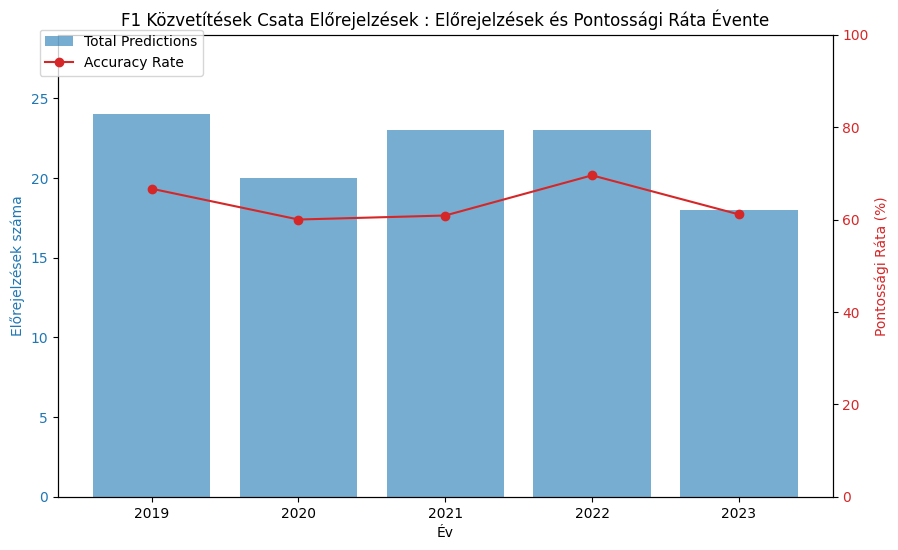

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for total predictions
color = 'tab:blue'
ax1.set_xlabel('Év')
ax1.set_ylabel('Előrejelzések száma', color=color)
ax1.bar(yearly_data['Year'], yearly_data['Total_Predictions'], color=color, alpha=0.6, label='Total Predictions')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(yearly_data['Total_Predictions']) + 5) 


# Adding a second y-axis for the accuracy rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Pontossági Ráta (%)', color=color)
ax2.plot(yearly_data['Year'], yearly_data['Accuracy_Rate'], color=color, marker='o', label='Accuracy Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 100)

# Adding a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adding a title
plt.title('F1 Közvetítések Csata Előrejelzések : Előrejelzések és Pontossági Ráta Évente')

plt.show()


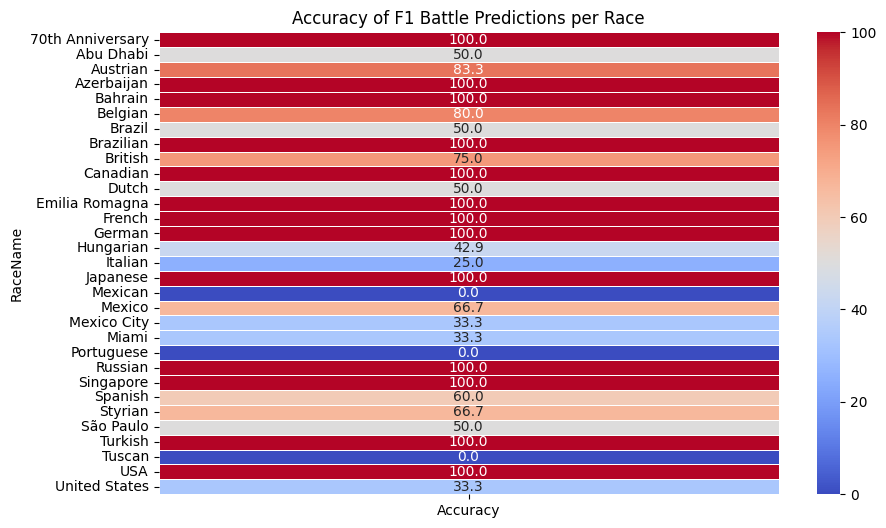

In [32]:
# Calculating accuracy for each race
race_accuracy = df_merged.groupby('RaceName').agg(
    Total_Predictions=pd.NamedAgg(column='isAccurate', aggfunc='size'),
    Accurate_Predictions=pd.NamedAgg(column='isAccurate', aggfunc='sum')
)
race_accuracy['Accuracy'] = (race_accuracy['Accurate_Predictions'] / race_accuracy['Total_Predictions']) * 100

# Preparing data for the heatmap (reshape for visual simplicity)
race_accuracy_heatmap = race_accuracy['Accuracy'].reset_index()
race_accuracy_heatmap = race_accuracy_heatmap.pivot_table(index='RaceName', values='Accuracy')

# Displaying the heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(race_accuracy_heatmap, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Accuracy of F1 Battle Predictions per Race')
plt.show()

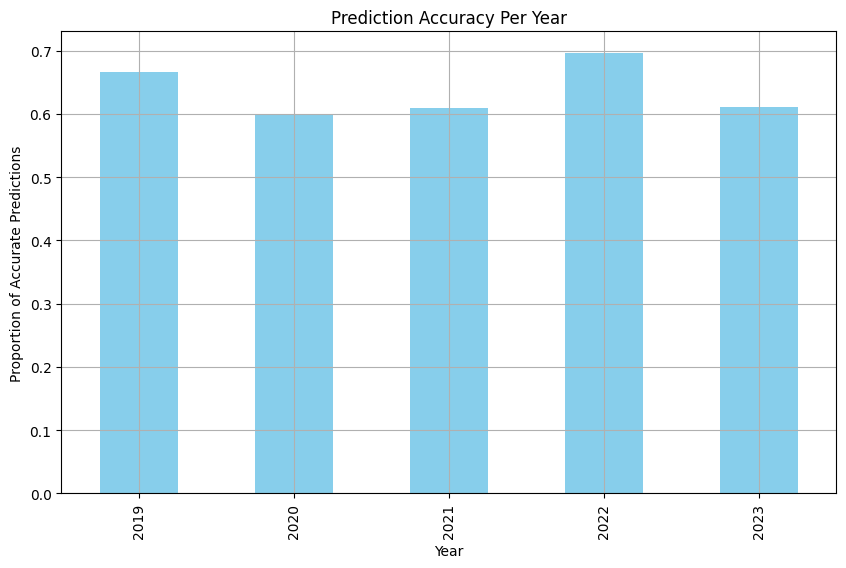

In [33]:
# Calculate the proportion of accurate predictions for each year
accuracy_per_year = df_merged.groupby('Year')['isAccurate'].mean()

# Plot the proportion of accurate predictions per year
plt.figure(figsize=(10, 6))
accuracy_per_year.plot(kind='bar', color='skyblue')
plt.title('Prediction Accuracy Per Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Accurate Predictions')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

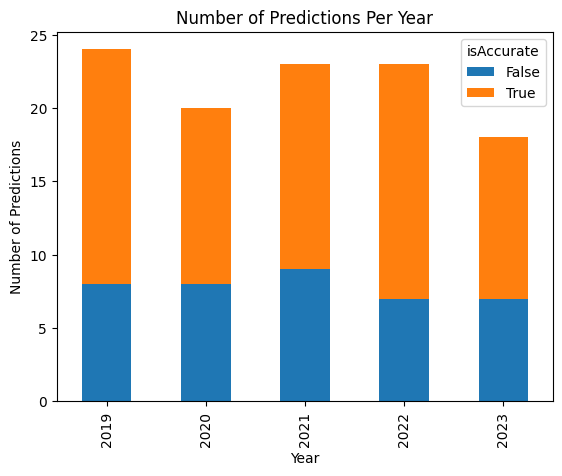

In [34]:
# Calculate the number of accurate and inaccurate predictions for each year
predictions_per_year = df_merged.groupby(['Year', 'isAccurate']).size().unstack()

# Plot the number of predictions per year
plt.figure(figsize=(10, 6))
predictions_per_year.plot(kind='bar', stacked=True)
plt.title('Number of Predictions Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Predictions')
plt.show()

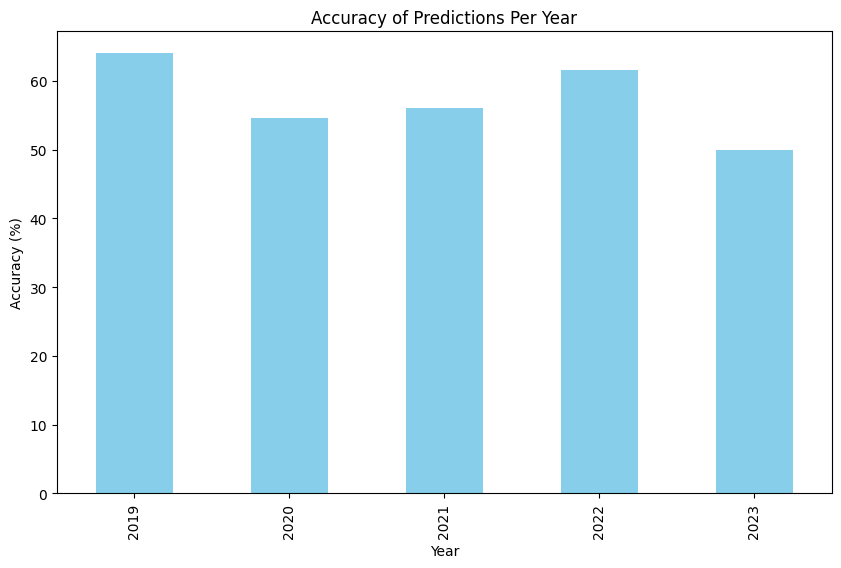

In [144]:
# Calculate the number of accurate and inaccurate predictions for each year
predictions_per_year = merged_data.groupby(['Year', 'isAccurate']).size().unstack()

# Calculate accuracy in percentage
predictions_per_year['Accuracy'] = predictions_per_year[True] / (predictions_per_year[True] + predictions_per_year[False]) * 100

# Plot the accuracy per year
plt.figure(figsize=(10, 6))
predictions_per_year['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy of Predictions Per Year')
plt.xlabel('Year')
plt.ylabel('Accuracy (%)')
plt.show()

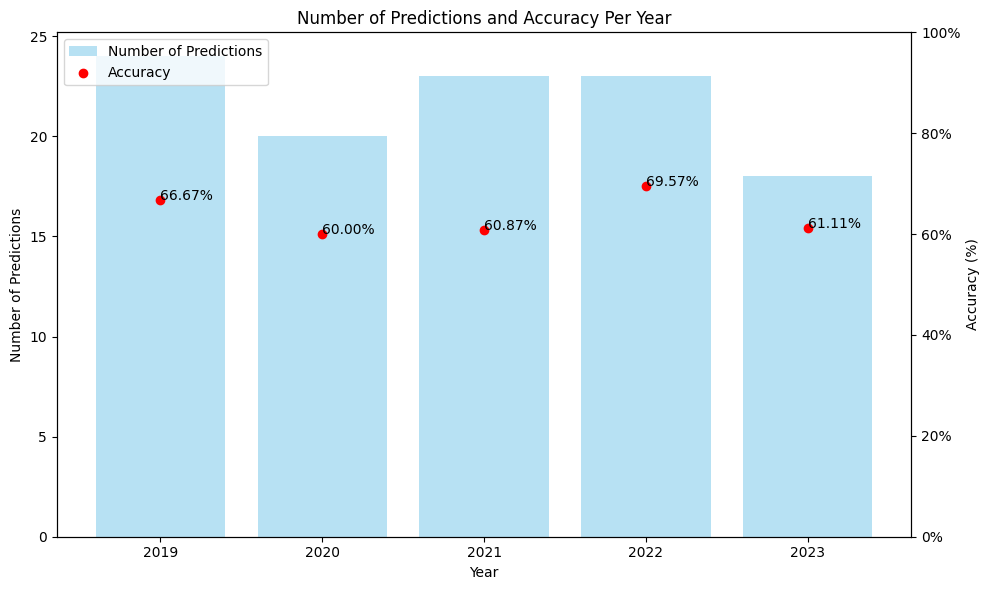

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Calculate the number of predictions and the accuracy for each year
predictions_per_year = df_merged.groupby('Year').agg({'RaceName': 'count', 'isAccurate': 'mean'}).rename(columns={'RaceName':'Count'})

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for the number of predictions per year
ax1.bar(predictions_per_year.index, predictions_per_year['Count'], color='skyblue', alpha=0.6, label='Number of Predictions')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Predictions')
ax1.tick_params(axis='y')

# Scatter plot for the accuracy on a secondary axis
ax2 = ax1.twinx()
ax2.scatter(predictions_per_year.index, predictions_per_year['isAccurate'], color='red', label='Accuracy')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_ylim([0,1])
ax2.set_ylabel('Accuracy (%)')
ax2.tick_params(axis='y')

# Annotate the dots with the exact accuracy
for i, txt in enumerate(predictions_per_year['isAccurate']):
    ax2.annotate(f'{txt:.2%}', (predictions_per_year.index[i], predictions_per_year['isAccurate'].iloc[i]))

# Show the legend
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

plt.title('Number of Predictions and Accuracy Per Year')
plt.tight_layout()
plt.show()

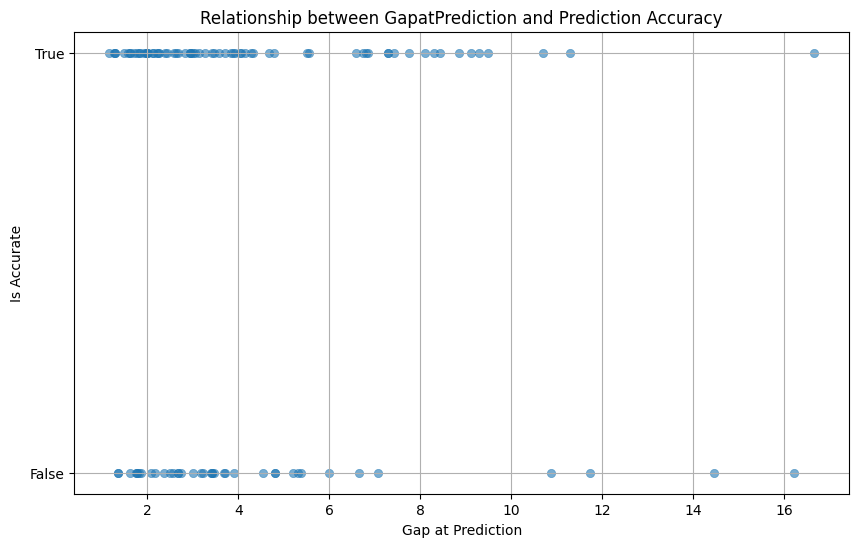

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GapatPrediction', y=np.where(df_merged['isAccurate'], 1, 0), alpha=0.6, edgecolor=None, data=df_merged)
plt.yticks([0, 1], ['False', 'True'])
plt.title('Relationship between GapatPrediction and Prediction Accuracy')
plt.xlabel('Gap at Prediction')
plt.ylabel('Is Accurate')
plt.grid(True)
plt.show()

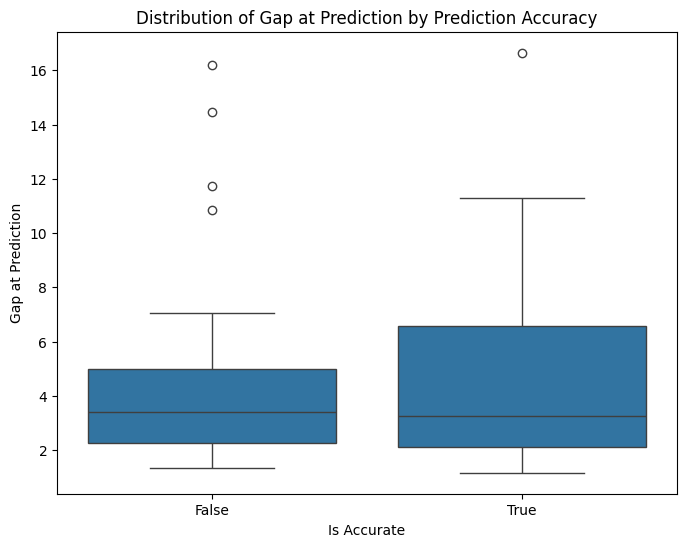

In [37]:
# Creating a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='isAccurate', y='GapatPrediction', data=df_merged)
plt.title('Distribution of Gap at Prediction by Prediction Accuracy')
plt.xlabel('Is Accurate')
plt.ylabel('Gap at Prediction')
plt.show()
